In [1]:
from typing import Dict
from IPython import display
import numpy as np
import torch
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

import seaborn as sns
sns.set_theme()

from src.deep_hedging.DeepHedge import DeepHedgeConfig, DeepHedge
from src.deep_hedging.DeepHedgeHeston import DeepHedgeHeston, DeepHedgeHestonConfig
from src.deep_hedging.DeepHedgeTrainer import DeepHedgeTrainer, DeepHedgeTrainerConfig
from src.deep_hedging.StrategyNet import StrategyNetConfig
from src.deep_hedging.objectives.HedgeObjective import MeanVariance, Entropy, StableEntropy, Std
from src.derivative.EuropeanCallOption import EuropeanCallOption
from src.gan.RobustDhGan import RobustDhGan
from src.generator.CoefficientNet import CoefficientNetConfig, CoefficientNet, DiffusionCoefficientNet
from src.generator.HestonCoefficient import HestonCoefficientConfig, HestonDriftCoefficient, HestonDiffusionCoefficient
from src.generator.SdeGenerator import GeneratorConfig, SdeGenerator
from src.generator.HestonGenerator import HestonGenerator as TrainableHestonGenerator
from src.generator.SdeGeneratorTrainer import SdeGeneratorTrainerConfig
from src.penalty.Augmentations import LeadLag, AddTimeComponent
from src.penalty.SigWassersteinMetric import SignatureConfig, SigWassersteinMetric
from src.util.TimeUtil import UniformTimeDiscretization
from src.util.processes.BlackScholesGenerator import BlackScholesGenerator
from src.util.processes.BrownianMotionGenerator import BrownianMotionGenerator
from src.util.processes.HestonGenerator import HestonParameterSet, HestonGenerator
from src.util.torch_util.AdapterUtil import Adapter, AdapterList, SelectDimensions, ConvertToIncrements
from src.util.torch_util.TrainingUtil import TrainerConfig
from src.util.torch_util.CallbackUtil import PrintMetrics, PrintGeneratorParameters, PrintEmptyLine
from src.util.VisualizationUtil import QuantityLogger

## Heston Generator

In [2]:
heston_parameters = HestonParameterSet(
    drift=0.0,
    reversion_level=0.04,
    reversion_speed=1,
    vol_of_vol=0.2,
    correlation=0.8,
)

In [3]:
trading_freq: int = 5
td = UniformTimeDiscretization(trading_freq * 1. / 255., 90 // trading_freq)
derivative = EuropeanCallOption(strike=1.0, time_discretization=td, price=0.0)

In [4]:
heston_coef_config = HestonCoefficientConfig(heston_parameters, initial_asset_price=1.0)

heston_drift_coef = HestonDriftCoefficient(heston_coef_config)
heston_diffusion_coef = HestonDiffusionCoefficient(heston_coef_config)

heston_gen_config = GeneratorConfig(
    td,
    heston_drift_coef.get_initial_asset_price,
    heston_drift_coef,
    heston_diffusion_coef,
)

heston_generator = TrainableHestonGenerator(generator_config=heston_gen_config)

In [5]:
noise_generator = BrownianMotionGenerator().provide_increment_generator(
    initial_value=np.zeros(2),
    times=td.times,
    random_number_generator=np.random.default_rng(4444),
)

In [6]:
reference_data = heston_generator(noise_generator(1000000)).detach()

## Heston Deep Hedge

In [7]:
hedge_objective = MeanVariance(84)

In [8]:
strategy_config = StrategyNetConfig(dimension_of_asset=1, number_of_layers=3, nodes_in_intermediate_layers=36)
dh_config = DeepHedgeConfig(derivative, torch.tensor([1.0]), strategy_config)

In [9]:
heston_deep_hedge = DeepHedge(dh_config)

In [10]:
sample_size = 50000
batch_sizes_for_epoch = [100]*5 + [1000]*3

In [11]:
try:
    heston_deep_hedge.load_state_dict(torch.load(f'resources/network-states/nsde_test/heston_dh_pre_trained.pt'))
    
except FileNotFoundError:
    generated = ConvertToIncrements()(heston_generator(noise_generator(sample_size)).detach()[:, :, 0:1])
    opt = torch.optim.Adam(heston_deep_hedge.parameters())

    utility_losses = QuantityLogger()
    bbar = tqdm(batch_sizes_for_epoch, leave=True)
    for batch_size in bbar:
        utility_losses.set_mark()
        pbar = tqdm(
            [generated[bno:min(bno + batch_size, sample_size)] for bno in range(0, sample_size, batch_size)],
            leave=False,
        )
        for batch in pbar:
            pnl = heston_deep_hedge(batch)
            loss = hedge_objective(pnl)
            heston_deep_hedge.zero_grad()
            loss.backward()
            opt.step()

            utility_losses.update(loss.item())
            pbar.set_postfix({'Loss': utility_losses.average_since_mark})

        bbar.set_postfix({'Loss': utility_losses.average_since_mark})

    torch.save(heston_deep_hedge.state_dict(), f'resources/network-states/nsde_test/heston_dh_pre_trained.pt') 

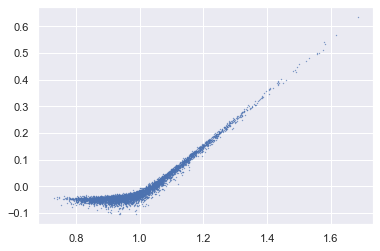

In [12]:
ref_increments = torch.diff(reference_data[:100000, :, 0:1], 1, 1)
terminal_values_on_test = np.sum(ref_increments.numpy(), axis=1)[:, 0] + 1.0

heston_deep_hedge.eval()
heston_deep_hedge_results = np.sum(heston_deep_hedge(ref_increments).detach().numpy() * ref_increments.numpy(), axis=1)
heston_deep_hedge.train()

plt.scatter(terminal_values_on_test[:5000], heston_deep_hedge_results[:5000, 0], s=.1)
plt.show()

## Robust Hedge GAN (Heston)

In [13]:
batch_size = 10000
number_of_batches = 200
batches = [noise_generator(batch_size) for _ in range(number_of_batches)]

In [14]:
pen_config = SignatureConfig(depth=2, augmentations=[AddTimeComponent(td), LeadLag()])
penalizer = SigWassersteinMetric(reference_data[:, :, 0:2], pen_config, transform=lambda x: 5000 * x)

In [15]:
dh = heston_deep_hedge
h_opt = torch.optim.Adam(dh.parameters())
h_scheduler = torch.optim.lr_scheduler.StepLR(h_opt, step_size=100)
h_adapter = ConvertToIncrements()

g = heston_generator
g_opt = torch.optim.Adam(g.parameters())
g_scheduler = torch.optim.lr_scheduler.StepLR(g_opt, step_size=100)

p = penalizer
p_adapter = SelectDimensions(dims=(0,1))

try:
    dh.load_state_dict(torch.load(f'resources/network-states/nsde_test/heston_rh_gan.pt'))

except FileNotFoundError:

    dh.train()

    h_losses = QuantityLogger()
    g_losses = QuantityLogger()

    pbar = tqdm(batches)
    for batch in pbar:
        # Update discriminator
        ## Forward pass
        generated = g(batch)
        profit_and_loss = dh(h_adapter(generated[:, :, 0:1]))
        hedge_loss = hedge_objective(profit_and_loss)
        ## Backward pass
        dh.zero_grad()
        hedge_loss.backward()
        h_opt.step()
        h_scheduler.step()
        h_losses.update(hedge_loss.item())

        # Update generator
        ## Forward pass
        generated = g(batch)
        profit_and_loss = dh(h_adapter(generated[:, :, 0:1]))
        hedge_loss = hedge_objective(profit_and_loss)
        penalty = p(p_adapter(generated))
        generation_loss = penalty - hedge_loss
        ## Backward pass
        g.zero_grad()
        generation_loss.backward()
        g_opt.step()
        g_scheduler.step()
        g_losses.update(generation_loss.item())

        pbar.set_postfix({
            'GLoss': g_losses.average,
            'HLoss': h_losses.average,
            'Penal': penalty.item(),
        })

    torch.save(dh.state_dict(), f'resources/network-states/nsde_test/heston_rh_gan.pt') 

In [16]:
heston_deep_hedge.eval()
heston_rh_gan_results = np.sum(heston_deep_hedge(ref_increments).detach().numpy() * ref_increments.numpy(), axis=1)
heston_deep_hedge.train()
None

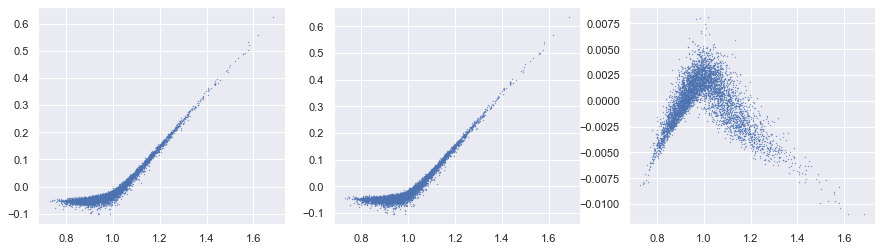

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(15,4))
axs[0].scatter(terminal_values_on_test[:5000], heston_rh_gan_results[:5000, 0], s=.1)
axs[1].scatter(terminal_values_on_test[:5000], heston_deep_hedge_results[:5000, 0], s=.1)
axs[2].scatter(terminal_values_on_test[:5000], heston_rh_gan_results[:5000, 0] - heston_deep_hedge_results[:5000, 0], s=.1)
plt.show()

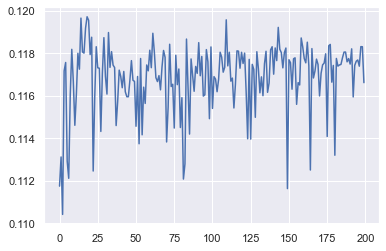

In [18]:
try:
    #plt.plot(h_losses.history)
    # plt.plot(g_losses.history)
    plt.plot(- np.array(g_losses.history) + np.array(h_losses.history))
except NameError:
    pass

## NSDE Generator

In [19]:
drift_coef_config = CoefficientNetConfig(
    number_of_layers=3,
    nodes_in_intermediate_layers=36,
    dim_of_process=2,
    transformation=lambda x: x[:, 1:2],
)
diffusion_coef_config = CoefficientNetConfig(
    number_of_layers=3,
    nodes_in_intermediate_layers=36,
    dim_of_process=2,
    transformation=lambda x: torch.abs(x),
)

drift_coef = CoefficientNet(drift_coef_config)
diffusion_coef = DiffusionCoefficientNet(diffusion_coef_config)

gen_config = GeneratorConfig(
    td, 
    initial_asset_price=None,
    drift_coefficient=drift_coef,
    diffusion_coefficient=diffusion_coef,
)

generator = SdeGenerator(gen_config)

In [20]:
try: 
    generator.load_state_dict(torch.load(f'resources/network-states/nsde_test/generator_calibrated.pt'))
except FileNotFoundError:
    gen_optimizer = torch.optim.Adam(generator.parameters()) # , lr=1e-4
    # gen_scheduler = torch.optim.lr_scheduler.StepLR(gen_optimizer, step_size=5, gamma=0.9)

    losses = QuantityLogger()
    pbar = tqdm(list(range(200)), leave=True)
    for i in pbar:
        if i%10 == 0:
            losses.set_mark()

        noise = noise_generator(50000)
        output = generator(noise)
        loss = penalizer(output)
        generator.zero_grad()
        loss.backward()
        gen_optimizer.step()
        # gen_scheduler.step()

        losses.update(loss.item())
        pbar.set_postfix({'Loss': losses.average_since_mark})

    torch.save(generator.state_dict(), f'resources/network-states/nsde_test/generator_calibrated.pt') 

In [21]:
plot_output = generator(noise_generator(100)).detach()

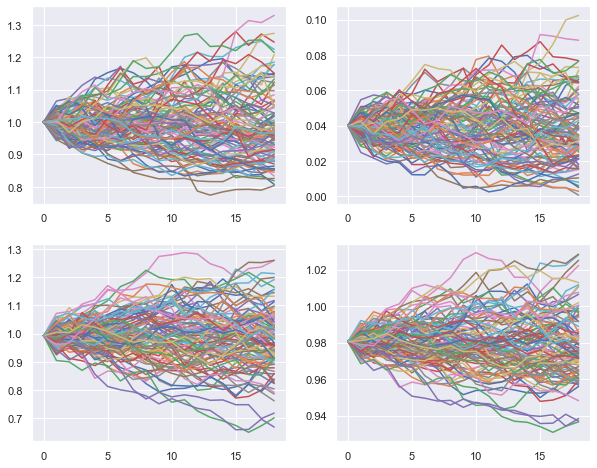

In [22]:
fig, axs = plt.subplots(2,2,figsize=(10,8))
for i in range(2):
    axs[0, i].plot(reference_data[:100, :, i].T)
    axs[1, i].plot(plot_output[:, :, i].T)
plt.show()

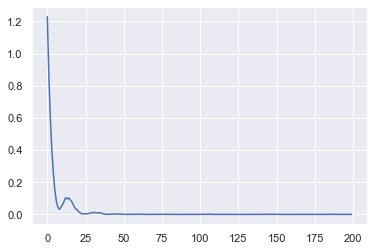

In [43]:
try:
    plt.plot(losses.history)
    plt.show()
except NameError:
    pass

## Deep Hedge

In [24]:
deep_hedge = DeepHedge(dh_config)

In [25]:
sample_size = 50000
batch_sizes_for_epoch = [100]*5 + [1000]*3

In [26]:
try:
    deep_hedge.load_state_dict(torch.load(f'resources/network-states/nsde_test/dh_pre_trained.pt'))
    
except FileNotFoundError:
    generated = ConvertToIncrements()(generator(noise_generator(sample_size)).detach()[:, :, 0:1])
    opt = torch.optim.Adam(deep_hedge.parameters())

    utility_losses = QuantityLogger()
    bbar = tqdm(batch_sizes_for_epoch, leave=True)
    for batch_size in bbar:
        losses.set_mark()
        pbar = tqdm(
            [generated[bno:min(bno + batch_size, sample_size)] for bno in range(0, sample_size, batch_size)],
            leave=False,
        )
        for batch in pbar:
            pnl = deep_hedge(batch)
            loss = hedge_objective(pnl)
            deep_hedge.zero_grad()
            loss.backward()
            opt.step()

            utility_losses.update(loss.item())
            pbar.set_postfix({'Loss': utility_losses.average_since_mark})

        bbar.set_postfix({'Loss': utility_losses.average_since_mark})

    torch.save(deep_hedge.state_dict(), f'resources/network-states/nsde_test/dh_pre_trained.pt') 

In [27]:
deep_hedge.eval()
deep_hedge_results = np.sum(deep_hedge(ref_increments).detach().numpy() * ref_increments.numpy(), axis=1)
deep_hedge.train()

print('Loss on test (Heston):', hedge_objective(heston_deep_hedge(ref_increments)).item())
print('Loss on test (NSDE):  ', hedge_objective(deep_hedge(ref_increments)).item())

Loss on test (Heston): 0.05255255103111267
Loss on test (NSDE):   0.05281727761030197


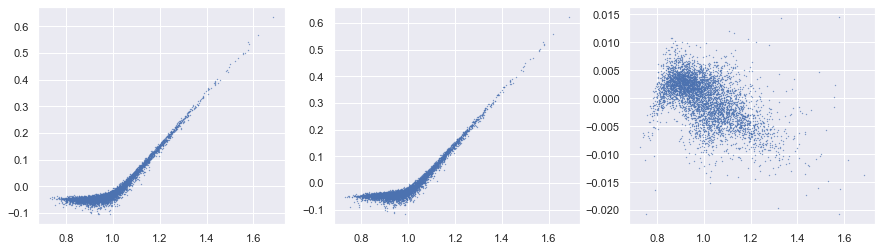

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(15,4))
axs[0].scatter(terminal_values_on_test[:5000], heston_deep_hedge_results[:5000, 0], s=.1)
axs[1].scatter(terminal_values_on_test[:5000], deep_hedge_results[:5000, 0], s=.1)
axs[2].scatter(terminal_values_on_test[:5000], deep_hedge_results[:5000, 0] - heston_deep_hedge_results[:5000, 0], s=.1)
plt.show()

# Robust Hedge GAN

In [29]:
dh = deep_hedge
h_opt = torch.optim.Adam(dh.parameters())
h_scheduler = torch.optim.lr_scheduler.StepLR(h_opt, step_size=100)
h_adapter = ConvertToIncrements()

g = generator
g_opt = torch.optim.Adam(g.parameters())
g_scheduler = torch.optim.lr_scheduler.StepLR(g_opt, step_size=100)

p = penalizer
p_adapter = SelectDimensions(dims=(0,1))

try:
    dh.load_state_dict(torch.load(f'resources/network-states/nsde_test/rh_gan.pt'))

except FileNotFoundError:

    dh.train()

    h_losses = QuantityLogger()
    g_losses = QuantityLogger()

    pbar = tqdm(batches)
    for batch in pbar:
        # Update discriminator
        ## Forward pass
        generated = g(batch)
        profit_and_loss = dh(h_adapter(generated[:, :, 0:1]))
        hedge_loss = hedge_objective(profit_and_loss)
        ## Backward pass
        dh.zero_grad()
        hedge_loss.backward()
        h_opt.step()
        h_scheduler.step()
        h_losses.update(hedge_loss.item())

        # Update generator
        ## Forward pass
        generated = g(batch)
        profit_and_loss = dh(h_adapter(generated[:, :, 0:1]))
        hedge_loss = hedge_objective(profit_and_loss)
        penalty = p(p_adapter(generated))
        generation_loss = penalty - hedge_loss
        ## Backward pass
        g.zero_grad()
        generation_loss.backward()
        g_opt.step()
        g_scheduler.step()
        g_losses.update(generation_loss.item())

        pbar.set_postfix({
            'GLoss': g_losses.average,
            'HLoss': h_losses.average,
            'Penal': penalty.item(),
        })

    torch.save(dh.state_dict(), f'resources/network-states/nsde_test/rh_gan.pt') 

In [30]:
deep_hedge.eval()
rh_gan_results = np.sum(deep_hedge(ref_increments).detach().numpy() * ref_increments.numpy(), axis=1)
deep_hedge.train()

DeepHedge(
  (strategy_layer): StrategyNet(
    (input_layer): Linear(in_features=2, out_features=36, bias=True)
    (intermediate_layers): ModuleDict(
      (IntermediateLayer0): Linear(in_features=36, out_features=36, bias=True)
      (IntermediateLayer1): Linear(in_features=36, out_features=36, bias=True)
      (IntermediateLayer2): Linear(in_features=36, out_features=36, bias=True)
    )
    (output_layer): Linear(in_features=36, out_features=1, bias=True)
  )
)

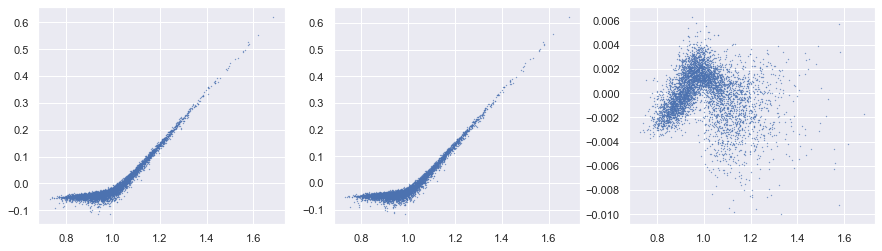

In [53]:
fig, axs = plt.subplots(1, 3, figsize=(15,4))
axs[0].scatter(terminal_values_on_test[:5000], rh_gan_results[:5000, 0], s=.1)
axs[1].scatter(terminal_values_on_test[:5000], deep_hedge_results[:5000, 0], s=.1)
axs[2].scatter(terminal_values_on_test[:5000], rh_gan_results[:5000, 0] - deep_hedge_results[:5000, 0], s=.1)
plt.show()

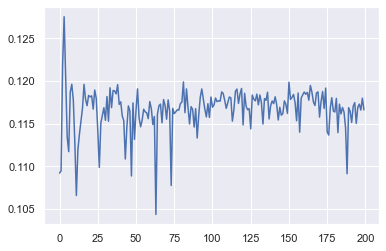

In [32]:
try:
    #plt.plot(h_losses.history)
    # plt.plot(g_losses.history)
    plt.plot(- np.array(g_losses.history) + np.array(h_losses.history))
except NameError:
    pass

In [55]:
# fig, axs = plt.subplots(1, 1, figsize=(6,5))
# axs.scatter(terminal_values_on_test[:5000], - heston_deep_hedge_results[:5000, 0] + heston_rh_gan_results[:5000, 0], s=.1)
# axs.scatter(terminal_values_on_test[:5000], - heston_deep_hedge_results[:5000, 0] + rh_gan_results[:5000, 0], s=.1)
# plt.show()

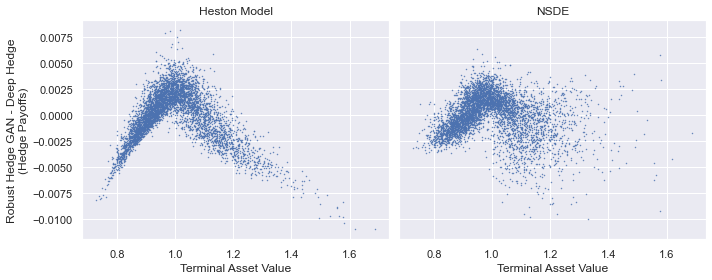

In [51]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10,4))
axs[0].scatter(terminal_values_on_test[:5000], - heston_deep_hedge_results[:5000, 0] + heston_rh_gan_results[:5000, 0], s=.2)
axs[0].set_ylabel('Robust Hedge GAN - Deep Hedge\n(Hedge Payoffs)')
axs[0].set_title('Heston Model')

axs[1].scatter(terminal_values_on_test[:5000], - deep_hedge_results[:5000, 0] + rh_gan_results[:5000, 0], s=.2)
axs[1].set_title('NSDE')
for ax in axs:
    ax.set_xlabel('Terminal Asset Value')
plt.tight_layout()
# plt.savefig('figs/NSDEvsHeston.pdf')
plt.show()

In [54]:
heston_generator.drift.reversion_level

Parameter containing:
tensor(0.0526, requires_grad=True)